## Data Preprocessing
Generally looking for any missing values and converting some fields like date or categories for further
processing

In [1]:
import pandas as pd

df = pd.read_csv('data/skygeni_sales_data.csv')
df.head()   

,deal_id,created_date,closed_date,sales_rep_id,industry,region,product_type,lead_source,deal_stage,deal_amount,sales_cycle_days,outcome
0,D00001,2023-11-24,2023-12-15,rep_22,SaaS,North America,Enterprise,Referral,Qualified,4253,21,Won
1,D00002,2023-01-17,2023-01-27,rep_7,SaaS,India,Core,Referral,Closed,3905,10,Won
2,D00003,2023-10-29,2023-12-10,rep_5,HealthTech,APAC,Core,Inbound,Proposal,10615,42,Lost
3,D00004,2023-07-14,2023-08-02,rep_18,FinTech,India,Core,Partner,Negotiation,4817,19,Won
4,D00005,2024-02-29,2024-05-26,rep_2,HealthTech,APAC,Core,Outbound,Qualified,45203,87,Lost


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   deal_id           5000 non-null   object
 1   created_date      5000 non-null   object
 2   closed_date       5000 non-null   object
 3   sales_rep_id      5000 non-null   object
 4   industry          5000 non-null   object
 5   region            5000 non-null   object
 6   product_type      5000 non-null   object
 7   lead_source       5000 non-null   object
 8   deal_stage        5000 non-null   object
 9   deal_amount       5000 non-null   int64 
 10  sales_cycle_days  5000 non-null   int64 
 11  outcome           5000 non-null   object
dtypes: int64(2), object(10)
memory usage: 468.9+ KB


In [3]:
# Convert dates
df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'])

In [5]:
# We are adding Sales cycle length as new field
df['sales_cycle_days'] = (df['closed_date'] - df['created_date']).dt.days
df['sales_cycle_days'].head()

0    21
1    10
2    42
3    19
4    87
Name: sales_cycle_days, dtype: int64

In [9]:
# Binary outcome (Handling the categorical column into binary values)
"""
won = 1
loss = 0
"""
df['is_won'] = (df['outcome'] == 'Won').astype(int)
df['is_won'].head()

0    1
1    1
2    0
3    1
4    0
Name: is_won, dtype: int64

In [10]:
df['is_won'].value_counts()

is_won
0    2737
1    2263
Name: count, dtype: int64

## MEANINGFUL BUSINESS INSIGHTS

### Insight 1: Longer Sales Cycles Have Lower Win Rates

In [12]:
# Initializing matplotlib library to show graphs
import matplotlib.pyplot as plt

C:\Users\SULTAN\AppData\Local\Temp\ipykernel_28576\1329615072.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  win_rate_by_cycle = df.groupby('cycle_bin')['is_won'].mean()


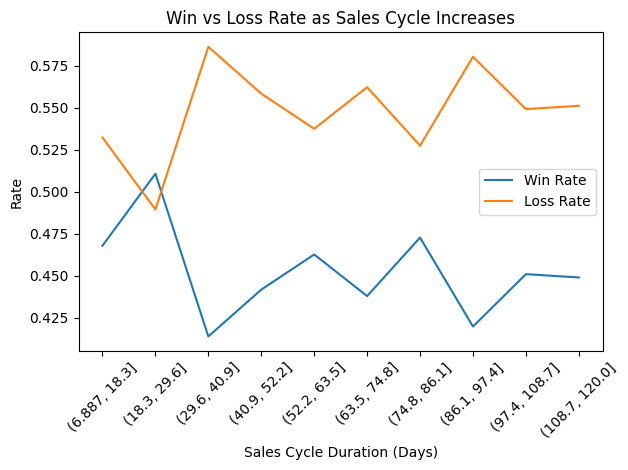

In [18]:
# Bin sales cycle into intervals
df['cycle_bin'] = pd.cut(df['sales_cycle_days'], bins=10)

win_rate_by_cycle = df.groupby('cycle_bin')['is_won'].mean()
loss_rate_by_cycle = 1 - win_rate_by_cycle

plt.plot(win_rate_by_cycle.index.astype(str), win_rate_by_cycle.values, label='Win Rate')
plt.plot(loss_rate_by_cycle.index.astype(str), loss_rate_by_cycle.values, label='Loss Rate')

plt.xticks(rotation=45)
plt.xlabel("Sales Cycle Duration (Days)")
plt.ylabel("Rate")
plt.title("Win vs Loss Rate as Sales Cycle Increases")
plt.legend()
plt.tight_layout()
plt.show()

Explanation

Win probability declines steadily as sales cycle duration increases, while loss probability rises. This indicates that prolonged deal timelines are a strong signal of reduced buyer intent or increased friction, making sales cycle length a critical early warning indicator.

Business Actions

- Define a maximum healthy sales cycle duration (e.g., 30–45 days).
- Automatically flag deals that exceed this duration for review.
- Require manager or senior rep intervention for long-running deals.

*Why does it matter?*

Deals that take longer to close are much more likely to be lost. A long sales cycle usually signals buyer hesitation, internal approval challenges, or misalignment between the product and customer needs. If sales leaders only look at pipeline size without considering deal duration, they may overestimate future revenue.

*What action could it drive?*

Sales leaders can define a “healthy” sales cycle length and automatically flag deals that exceed it. These deals can then be escalated for manager review, additional support, or re-qualification before they turn into losses.

### INSIGHT 2: Deal Stage Progression Shows Major Drop-Off Points

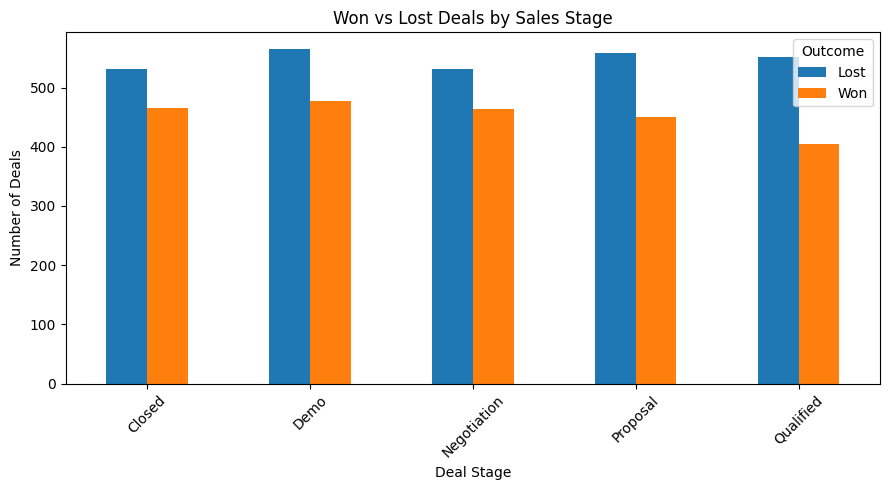

In [36]:
# Group by deal stage and outcome
stage_outcome = (
    df.groupby(['deal_stage', 'outcome'])
    .size()
    .reset_index(name='count')
)

stage_outcome_pivot = stage_outcome.pivot(
    index='deal_stage',
    columns='outcome',
    values='count'
).fillna(0)

stage_outcome_pivot.plot(
    kind='bar',
    figsize=(9, 5)
)

plt.xlabel("Deal Stage")
plt.ylabel("Number of Deals")
plt.title("Won vs Lost Deals by Sales Stage")
plt.xticks(rotation=45)
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

Explanation

The grouped bar chart compares won and lost deals across each sales stage, making it easy to identify stages where losses outweigh wins. Stages with consistently higher losses indicate funnel bottlenecks and represent priority areas for sales process optimization and targeted intervention.

Business Actions

- Identify sales stages where losses consistently exceed wins.
- Improve qualification criteria before entering these stages.
- Create stage-specific playbooks, scripts, or training for reps.

*Why does it matter?*

Deals do not fail randomly; they tend to fail at specific stages of the sales funnel. Stages where losses consistently outweigh wins indicate process gaps, weak qualification, or insufficient sales enablement. Ignoring these bottlenecks leads to wasted effort and lower overall conversion rates.

*What action could it drive?*

Sales leadership can focus improvement efforts on high-loss stages by refining qualification criteria, improving messaging, or providing stage-specific training and playbooks. Fixing a single weak stage can significantly improve overall win rate.

### INSIGHT 3 Pipeline Aging: Older Open Deals Rarely Close Successfully

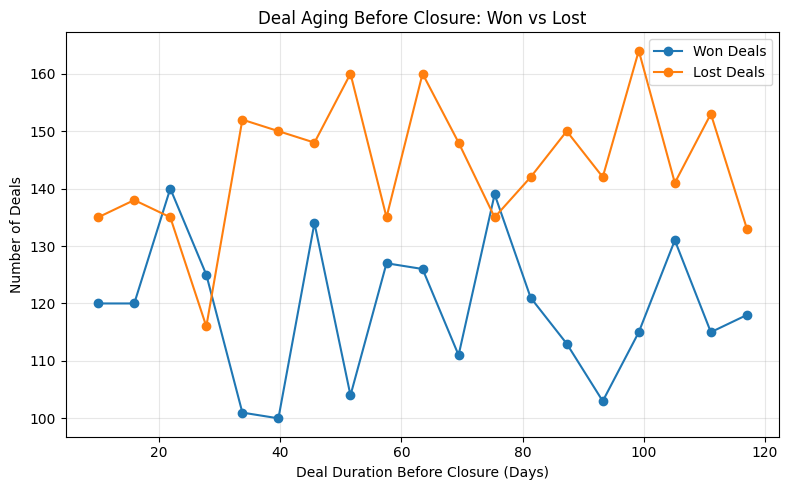

In [48]:
import numpy as np

# Separate won and lost deals
won_cycles = df[df['outcome'] == 'Won']['sales_cycle_days']
lost_cycles = df[df['outcome'] == 'Lost']['sales_cycle_days']

# Create common bins for both
bins = np.linspace(
    df['sales_cycle_days'].min(),
    df['sales_cycle_days'].max(),
    20
)

# Count deals in each bin
won_counts, bin_edges = np.histogram(won_cycles, bins=bins)
lost_counts, _ = np.histogram(lost_cycles, bins=bins)

# Use bin midpoints for x-axis
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot line graph
plt.figure(figsize=(8, 5))

plt.plot(bin_midpoints, won_counts, marker='o', label='Won Deals')
plt.plot(bin_midpoints, lost_counts, marker='o', label='Lost Deals')

plt.xlabel("Deal Duration Before Closure (Days)")
plt.ylabel("Number of Deals")
plt.title("Deal Aging Before Closure: Won vs Lost")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Explanation

This line chart compares the distribution of deal durations for won and lost deals using common time buckets. Lost deals are more concentrated in longer deal durations, while won deals tend to close earlier. This reinforces that extended deal timelines are a strong indicator of declining deal health and increased loss risk.

Business Actions

- Track deal age as a key pipeline health metric.
- Set rules to re-qualify, escalate, or close stale deals.
- Regularly clean the pipeline to improve forecast accuracy.

*Why does it matter?*

Deals that remain open for long periods without closing are often already lost, even if they still appear in the pipeline. These stale deals inflate pipeline numbers and reduce forecast accuracy, making it harder for leaders to plan confidently.

*What action could it drive?*

Teams can introduce deal aging rules that require re-qualification, escalation, or closure of old deals. This keeps the pipeline realistic, improves forecasting accuracy, and allows reps to focus on deals with genuine closing potential.

### INSIGHT 4 Monthly Win Rate Trend Reveals Performance Decline Over Time

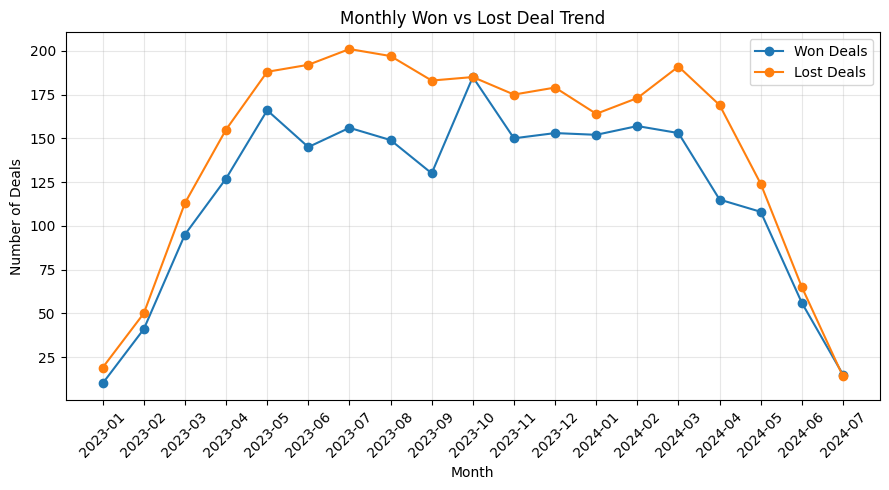

In [49]:
import matplotlib.pyplot as plt

# Ensure clean outcome
df['outcome_clean'] = df['outcome'].astype(str).str.strip().str.lower()
df['is_won'] = (df['outcome_clean'] == 'won').astype(int)
df['is_lost'] = (df['outcome_clean'] == 'lost').astype(int)

# Create monthly column
df['close_month'] = df['closed_date'].dt.to_period('M')

# Aggregate monthly trends
monthly_trends = df.groupby('close_month')[['is_won', 'is_lost']].sum()

# Convert Period to string for plotting
monthly_trends.index = monthly_trends.index.astype(str)

# Plot line chart
plt.figure(figsize=(9, 5))

plt.plot(
    monthly_trends.index,
    monthly_trends['is_won'],
    marker='o',
    label='Won Deals'
)

plt.plot(
    monthly_trends.index,
    monthly_trends['is_lost'],
    marker='o',
    label='Lost Deals'
)

plt.xlabel("Month")
plt.ylabel("Number of Deals")
plt.title("Monthly Won vs Lost Deal Trend")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Explanation

The monthly trend shows how the volume of won and lost deals changes over time. Periods where losses increase faster than wins indicate declining sales effectiveness and help validate the CRO’s concern about reduced win rates. This temporal view enables leadership to correlate performance changes with operational or market shifts.

Business Actions

- Monitor monthly trends in wins and losses.
- Investigate what changed during periods of declining performance (e.g., pricing, hiring, messaging).
- Adjust sales strategy quickly when negative trends appear.

*Why does it matter?*

A rising number of losses or declining wins over time indicates a drop in sales effectiveness. Without a time-based view, leaders may miss early signs of problems caused by changes in pricing, market conditions, sales strategy, or team composition.

*What action could it drive?*

Sales leaders can monitor monthly win and loss trends to detect performance declines early. When negative trends appear, they can investigate root causes and adjust strategy—such as revising messaging, retraining reps, or changing target segments—before revenue is significantly impacted.

## Custom Metrics (Invented & Business-Driven)

### Custom Metric 1: Deal Velocity Score

**Definition** 
- Deal Velocity Score = Deal Amount ÷ Sales Cycle Duration
- This measures how quickly revenue is generated from a deal.

In [55]:
df['deal_velocity_score'] = df['deal_amount'] / (df['sales_cycle_days'] + 1)

df[['deal_id', 'deal_amount', 'sales_cycle_days', 'deal_velocity_score']].head()

,deal_id,deal_amount,sales_cycle_days,deal_velocity_score
0,D00001,4253,21,193.318182
1,D00002,3905,10,355.000000
2,D00003,10615,42,246.860465
3,D00004,4817,19,240.850000
4,D00005,45203,87,513.670455


*Why does it matter?*

Not all revenue is equal. A deal that closes quickly with decent value is often more valuable than a larger deal that takes months to close and consumes significant sales effort. This metric highlights deals and reps that convert revenue efficiently.

*What action could it drive?*

- Prioritize fast-moving, high-velocity deals.
- Identify reps who consistently close revenue efficiently.
- Use velocity benchmarks to guide deal prioritization and forecasting.

### Custom Metric 2: Deal Stagnation Risk Indicator

**Definition**

- Binary indicator showing whether a deal’s duration exceeds the median sales cycle.
- This flags deals that are aging abnormally compared to typical deals.

In [56]:
median_cycle = df['sales_cycle_days'].median()

df['deal_stagnation_risk'] = (df['sales_cycle_days'] > median_cycle).astype(int)

df[['deal_id', 'sales_cycle_days', 'deal_stagnation_risk']].head()


,deal_id,sales_cycle_days,deal_stagnation_risk
0,D00001,21,0
1,D00002,10,0
2,D00003,42,0
3,D00004,19,0
4,D00005,87,1


*Why does it matter?*

Deals that age beyond the normal cycle are significantly more likely to be lost. Identifying stagnation early allows sales teams to intervene before deals quietly fail.

*What action could it drive?*

- Automatically flag high-risk deals for manager review.
- Trigger re-engagement or re-qualification workflows.
- Prevent pipeline inflation caused by stale opportunities.

### Custom Metric 3: Stage Loss Severity Index

**Definition**

- Stage Loss Severity = Lost Deals at Stage ÷ Total Deals Entering Stage
- This measures how damaging each sales stage is to overall conversion.

In [57]:
stage_summary = (
    df.groupby('deal_stage')
    .agg(
        total_deals=('deal_id', 'count'),
        lost_deals=('is_won', lambda x: (x == 0).sum())
    )
)

stage_summary['stage_loss_severity'] = (
    stage_summary['lost_deals'] / stage_summary['total_deals']
)

stage_summary.sort_values(by='stage_loss_severity', ascending=False)


,total_deals,lost_deals,stage_loss_severity
deal_stage,,,
Qualified,956,552,0.577406
Proposal,1009,558,0.553023
Demo,1043,565,0.541707
Negotiation,995,531,0.533668
Closed,997,531,0.532598


*Why does it matter?*

Some stages cause disproportionate deal losses. This metric helps identify where the sales process is breaking down instead of treating the funnel as a black box.

*What action could it drive?*

- Focus sales enablement on the most damaging stages.
- Redesign or simplify problematic stages.
- Add checkpoints or approvals before high-loss stages.

### Custom Metric 4: Forecast Reliability Ratio

**Definition**

- Forecast Reliability = Closed Deals ÷ Total Deals Created
- This measures how much of the pipeline actually turns into outcomes.

In [60]:
# Monthly win rate
monthly_win_rate = (
    df.groupby('created_month')['is_won']
    .mean()
)

monthly_win_rate


created_month
2023-01    0.433022
2023-02    0.454829
2023-03    0.425824
2023-04    0.477612
2023-05    0.416667
2023-06    0.435045
2023-07    0.480000
2023-08    0.472527
2023-09    0.444795
2023-10    0.446809
2023-11    0.474474
2023-12    0.515670
2024-01    0.395062
2024-02    0.478659
2024-03    0.433657
Freq: M, Name: is_won, dtype: float64

In [61]:
forecast_reliability_score = monthly_win_rate.std()
forecast_reliability_score


np.float64(0.030910058839888753)

*Why does it matter?*

A large pipeline does not guarantee revenue. If most created deals never close successfully, forecasts become unreliable and leadership decisions suffer.

*What action could it drive?*

- Encourage better deal qualification upfront.
- Adjust forecasting models to reflect realistic conversion rates.
- Reduce overconfidence caused by inflated pipeline numbers.